In [2]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from collections import defaultdict, Counter

In [10]:
from torch.utils.data.sampler import *
from torch.utils.data import DataLoader

### `SequentialSampler`
same as `shuffle=False`

In [11]:
dset = range(10)
dl_train = DataLoader(dset, batch_size=2, sampler=SequentialSampler(dset))

for x in dl_train:
    print(x)

tensor([0, 1])
tensor([2, 3])
tensor([4, 5])
tensor([6, 7])
tensor([8, 9])


### `RandomSampler`
same as `shuffle=True`

In [12]:
dset = range(10)
dl_train = DataLoader(dset, batch_size=2, sampler=RandomSampler(dset))

for x in dl_train:
    print(x)

tensor([6, 9])
tensor([5, 4])
tensor([1, 0])
tensor([2, 3])
tensor([7, 8])


### `SubsetRandomSampler`
Only sample even samples 

In [13]:
dset = range(20)
idx = torch.tensor(dset) % 2 == 0
dl_train = DataLoader(dset, batch_size=2, sampler=SubsetRandomSampler(np.where(idx)[0]))

for x in dl_train:
    print(x)

tensor([12,  6])
tensor([ 8, 18])
tensor([2, 4])
tensor([ 0, 10])
tensor([14, 16])


### `WeightedRandomSampler`

The weighted sampling should be used for training, to balance the classes in each batch, when there are unbalanced classes in the dataset.

First we create a custom dataset with unbalanced labels. This dataset has two classes: calss 0 has 10 samples and class 1 has 30 samples

In [170]:
class Dset(torch.utils.data.Dataset):
    def __init__(self):
        super(Dset, self).__init__()
        x = list(zip(np.arange(40), [0]*5 + [1]*35))
        np.random.shuffle(x)
        self.data = torch.tensor([y for (y, _) in x])
        self.targets = [y for (_, y) in x ]

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        return self.data[i], self.targets[i]
    
dset = Dset()    

In [175]:
# a simple uniform random sampler
dl = DataLoader(dset, batch_size=4, shuffle=True)
for x, y in dl:
    print(x, y)

tensor([35, 19,  7, 17]) tensor([1, 1, 1, 1])
tensor([16, 24, 15, 29]) tensor([1, 1, 1, 1])
tensor([ 6, 26, 34, 37]) tensor([1, 1, 1, 1])
tensor([ 0,  3,  4, 20]) tensor([0, 0, 0, 1])
tensor([14, 11, 23, 22]) tensor([1, 1, 1, 1])
tensor([38,  8, 28, 36]) tensor([1, 1, 1, 1])
tensor([25, 13, 10,  2]) tensor([1, 1, 1, 0])
tensor([ 9, 33,  5, 31]) tensor([1, 1, 1, 1])
tensor([18, 21, 39,  1]) tensor([1, 1, 1, 0])
tensor([30, 12, 27, 32]) tensor([1, 1, 1, 1])


We can see that the batches are not balanced, causing the training to overfit 

In [176]:
# Weighted random sampler
batch_size = 4
class_count = Counter([i_label for (_, i_label) in dset])


weight = {k: 1./v for k, v in class_count.items()}
sample_weight = [weight[i] for _, i in dset]

print(f'class count: {class_count}')
print(f'class weight: {weight}')

dl = DataLoader(dset, batch_size=batch_size,
                sampler=WeightedRandomSampler(sample_weight, len(dset), replacement=True))

for x, y in dl:
    print(x, y)


class count: Counter({1: 35, 0: 5})
class weight: {1: 0.02857142857142857, 0: 0.2}
tensor([ 2,  6,  5, 15]) tensor([0, 1, 1, 1])
tensor([22, 24,  1, 10]) tensor([1, 1, 0, 1])
tensor([ 9, 23, 38, 28]) tensor([1, 1, 1, 1])
tensor([ 0,  2,  1, 10]) tensor([0, 0, 0, 1])
tensor([17, 17,  3, 29]) tensor([1, 1, 0, 1])
tensor([ 1,  0, 20,  1]) tensor([0, 0, 1, 0])
tensor([1, 3, 5, 2]) tensor([0, 0, 1, 0])
tensor([ 2, 20, 13,  0]) tensor([0, 1, 1, 0])
tensor([ 2, 24, 29,  7]) tensor([0, 1, 1, 1])
tensor([0, 2, 0, 2]) tensor([0, 0, 0, 0])


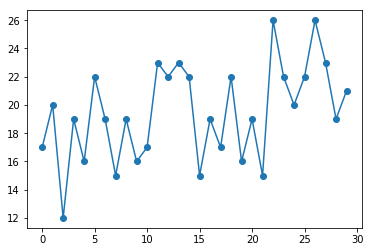

In [174]:
ys_sum = []
for i in range(30):
    ys = torch.tensor([], dtype=torch.long)
    for x, y in dl:
        ys = torch.cat([ys, y])

    ys_sum.append(torch.sum(ys))
plt.plot(ys_sum, '-o')

Which shows the class spread is uniform (hovers around 20)

## create validation sets from training set

In [180]:
def datasets(DataSet, root, transformers):
    return DataSet(root, transform=transformers, download=True, train=True), \
           DataSet(root, transform=transformers, download=True, train=False)

In [182]:
import torchvision.transforms as transforms
import torch.utils.data.sampler as sampler
from torch.utils.data import DataLoader

transformers = transforms.Compose([
    transforms.Resize(28),
    transforms.CenterCrop(28),
    transforms.ToTensor()])

MNIST_train, MNIST_test = datasets(torchvision.datasets.MNIST, '.', transformers)

transformers = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()])

CIFAR10_train, CIFAR10_test = datasets(torchvision.datasets.CIFAR10, '.', transformers)
CIFAR100_train, CIFAR100_test = datasets(torchvision.datasets.CIFAR100, '.', transformers)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Using a subset of dataset for training
There are two ways of doing this: 
- Creating new datasets that include the subset and then create data loaders with uniform sampling
- Define dataloader with `SubsetRandomSampling` sampler

with `CIFAR100`

In [220]:
idx = torch.tensor(CIFAR100_train.targets) == 10
idx += torch.tensor(CIFAR100_train.targets) == 12
dset_train = torch.utils.data.dataset.Subset(CIFAR100_train, np.where(idx==1)[0])

idx = torch.tensor(CIFAR100_test.targets) == 10
idx += torch.tensor(CIFAR100_test.targets) == 12
dset_test = torch.utils.data.dataset.Subset(CIFAR100_test, np.where(idx==1)[0])

In [228]:
factor = 0.8
trainset_length = len(dset_train)

idx_train = torch.arange(int(factor * trainset_length))
idx_validation = torch.arange(int(factor * trainset_length), trainset_length)

dl_train = DataLoader(dset_train, batch_size=8, sampler=SubsetRandomSampler(idx_train))
dl_validation = DataLoader(dset_train, batch_size=8, sampler=SubsetRandomSampler(idx_validation))
dl_test = DataLoader(dset_test, batch_size=8, shuffle=True)

In [229]:
img_train, _ = next(iter(dl_train))
img_test, _ = next(iter(dl_test))

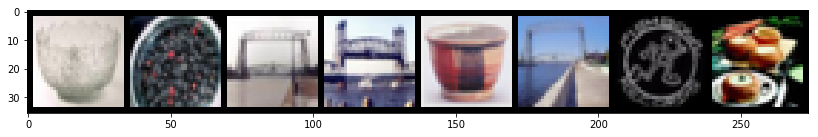

In [230]:
fig, ax = plt.subplots(figsize=(14, 3))
plt.imshow(torchvision.utils.make_grid(img_train).transpose(0, 2).transpose(0, 1))

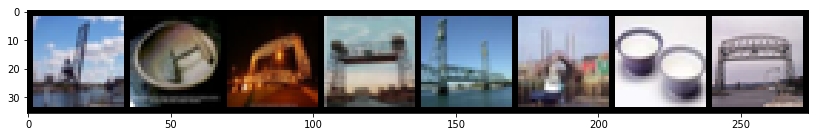

In [232]:
fig, ax = plt.subplots(figsize=(14, 3))
plt.imshow(torchvision.utils.make_grid(img_test).transpose(0, 2).transpose(0, 1))

and with `MNIST`. This time we only use the digits `1` and `2` for out dataset.

In [234]:
idx = MNIST_train.targets == 1
idx += MNIST_train.targets == 2
dset_train = torch.utils.data.dataset.Subset(MNIST_train, np.where(idx==1)[0])

idx = MNIST_test.targets == 1
idx += MNIST_test.targets == 2
dset_test = torch.utils.data.dataset.Subset(MNIST_test, np.where(idx==1)[0])

In [236]:
factor = 0.8
trainset_length = len(dset_train)

idx_train = torch.arange(int(factor * trainset_length))
idx_validation = torch.arange(int(factor * trainset_length), trainset_length)

dl_train = DataLoader(dset_train, batch_size=8, sampler=SubsetRandomSampler(idx_train))
dl_validation = DataLoader(dset_train, batch_size=8, sampler=SubsetRandomSampler(idx_validation))
dl_test = DataLoader(dset_test, batch_size=8, shuffle=True)

In [237]:
img_train, _ = next(iter(dl_train))
img_test, _ = next(iter(dl_test))

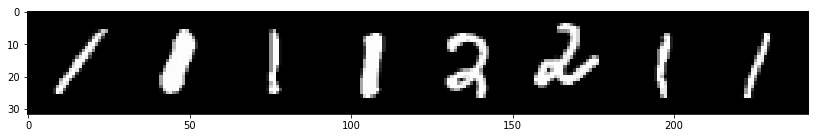

In [238]:
fig, ax = plt.subplots(figsize=(14, 3))
plt.imshow(torchvision.utils.make_grid(img_train).transpose(0, 2).transpose(0, 1))

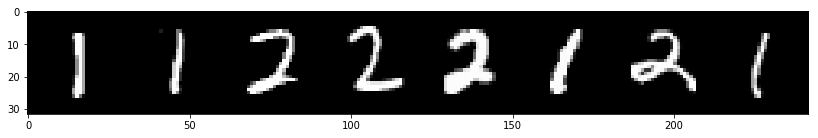

In [239]:
fig, ax = plt.subplots(figsize=(14, 3))
plt.imshow(torchvision.utils.make_grid(img_test).transpose(0, 2).transpose(0, 1))